In [1]:
import numpy as np
import pandas as pd
from datetime import time, datetime
from os import path
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import math
from math import pi
import seaborn as sns

In [3]:
%matplotlib inline
sns.set()
red = (255/255,103/255,103/255)
blue = (52/255,128/255,255/255)

Load data

In [4]:
case_qbs = pd.read_csv('qb-data/case_qbs.csv')
ctrl_qbs = pd.read_csv('qb-data/ctrl_qbs.csv')
select_ctrls = {'Alex Smith': 'Michael Vick',
 'Andrew Luck': 'Joe Flacco',
 'Cam Newton': 'Robert Griffin III',
 'Chad Pennington': 'Tony Romo',
 'Don Majkowski': 'Erik Kramer',
 'Drew Brees': 'Peyton Manning',
 'Jay Cutler': 'Matt Schaub',
 'Jim McMahon': 'Jim Everett',
 'Jimmy Clausen': 'Kellen Clemens',
                'Kelly Holcomb': 'Donald Hollas',
#  'Kelly Holcomb': 'Jim Miller',
 'Mark Sanchez': 'Kyle Orton',
 'Matt Moore': 'Geno Smith',
 'Matthew Stafford': 'Drew Bledsoe',
 'Rich Gannon': 'Tommy Kramer',
 'Ryan Leaf': 'Tim Couch',
 'Steve McNair': 'Donovan McNabb',
 'Tom Brady': 'Brett Favre',
 'Troy Aikman': 'John Elway',
 'Gary Danielson': 'Jim Kelly'}

Define methods

In [5]:
def format_date(date):
    month_i = date.find('/', 3)
    day_i = date.find('/')
    month = date[:day_i]
    day = date[day_i+1:month_i]
    if len(day)==1:
        day = '0'+day
    if len(month)==1:
        month = '0'+month
    newdate = date[-4:]+'-'+month+'-'+day
    return newdate

def underscore(name):
    sep = name.find(' ')
    return name[:sep]+'_'+name[sep+1:]

def get_qb_stats(name, attempts=1, average=False):
    filesuff = '{}.csv'.format(underscore(name))
    if path.exists('qb-data/case/'+filesuff):
        df = pd.read_csv('qb-data/case/'+filesuff)
    elif path.exists('qb-data/control/'+filesuff):
        df = pd.read_csv('qb-data/control/'+filesuff)
    else:
        return 
    
    df = df[df['Att']>attempts]
    df.reset_index(drop=True, inplace=True)
    
    if average:
        return df.mean()
    
    return df

def get_qb_games(name, date, all_games=False, games=0, average=False, before=False, after=False):
    # get qb stats if they exist
    df = get_qb_stats(name)
    if df is None:
        return
    
    # format date
    if '/' in date:
        date = format_date(date)
    i = 0
    for d in df['Date']:
        if d>=date:
            break
        else:
            i+=1
            
    # get all previous/after games
    if all_games:
        if before and not after:
            df = df.iloc[0:i,:].reset_index(drop=True)
        elif after and not before:
            df = df.iloc[i:,:].reset_index(drop=True)
    # get just the specified number of previous/after games
    else:
        if before:
            before_i = 0 if i-games<0 else i-games
            df = df.iloc[before_i:i,:].reset_index(drop=True)
        elif after:
            df = df.iloc[i:i+games,:].reset_index(drop=True)
        else: 
            df = df.iloc[i-games:i+games,:].reset_index(drop=True)
            
    # average all stats per game, if average
    if average:
        newdf = pd.DataFrame(data={'Games': len(df), 'Age': [df['Age'].mean()], 'Cmp': [df['Cmp'].mean()], 'Att': [df['Att'].mean()], 'Cmp%': [df['Cmp%'].mean()], 'Yds': [df['Yds'].mean()], 'TD': [df['TD'].mean()], 'Int': [df['Int'].mean()], 'Rate': [df['Rate'].mean()], 'Sk': [df['Sk'].mean()], 'Yds.1': [df['Yds.1'].mean()], 'Y/A': [df['Y/A'].mean()], 'AY/A': [df['AY/A'].mean()]})
        return newdf
    else:
        return df 
    
def get_qb_stats_by_age(name, age, all_games=True, n_games=0, before=False, after=False):
    stats = get_qb_stats(name)
    if stats is None:
        return
    for a in stats['Age']:
        if a>age:
            qb_age = a
            break
    if age>a:
        return
    qb_date = stats[stats['Age']==qb_age]['Date'].to_string(index=False)[1:] 
        
    if all_games:
        if after:
            result = get_qb_games(name, qb_date, all_games=True, average=True, after=True)
        else:
            result = get_qb_games(name, qb_date, all_games=True, average=True, before=True)
    else:
        if after:
            result = get_qb_games(name, qb_date, games=n_games, average=False, after=True)
        else:
            result = get_qb_games(name, qb_date, games=n_games, average=True, before=True)

    return result

def get_before_after_age(qblist):
    prev = pd.DataFrame()
    post = pd.DataFrame()
    for i, row in qblist.iterrows():
        prev_qb = get_qb_stats_by_age(row.Name, row.SurgeryAge, before=True)
        post_qb = get_qb_stats_by_age(row.Name, row.SurgeryAge, after=True)
        prev_qb['Name'] = row.Name
        post_qb['Name'] = row.Name
        prev = prev.append(prev_qb)
        post = post.append(post_qb)
    prev.reset_index(drop=True, inplace=True)
    post.reset_index(drop=True, inplace=True)
    cols = list(prev.columns)
    cols = cols[-1:] + cols[:-1]
    prev = prev[cols]
    post = post[cols]
    return prev, post

def compile_before_after(caseslist, controlslist):
    compare_qbs = pd.DataFrame()
    for i, row in caseslist.iterrows():
        case_prev = get_qb_stats_by_age(row.Name, row.SurgeryAge, before=True)
        case_post = get_qb_stats_by_age(row.Name, row.SurgeryAge, after=True)
        ctrl_prev = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, before=True)
        ctrl_post = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, after=True)
        case = case_prev.append(case_post)
        case['Name'] = row.Name
        ctrl = ctrl_prev.append(ctrl_post)
        ctrl['Name'] = select_ctrls[row.Name]
        compare_qbs = compare_qbs.append(case)
        compare_qbs = compare_qbs.append(ctrl)
    compare_qbs.reset_index(drop=True, inplace=True)
    cols = list(compare_qbs.columns)
    cols = cols[-1:] + cols[:-1]
    compare_qbs = compare_qbs[cols]
    return compare_qbs

def get_case_control_prev_post(caseslist, controlslist):
    compare = compile_before_after(caseslist, controlslist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(3,len(compare),4):
            droplist.append(i)
    ctrl_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(2,len(compare),4):
            droplist.append(i)
    ctrl_prev = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(1,len(compare),4):
            droplist.append(i)
    case_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(0,len(compare),4):
            droplist.append(i)
    case_prev = compare.drop(index=droplist)
    ctrl_post.reset_index(drop=True, inplace=True)
    ctrl_prev.reset_index(drop=True, inplace=True)
    case_post.reset_index(drop=True, inplace=True)
    case_prev.reset_index(drop=True, inplace=True)
    return case_prev, ctrl_prev, case_post, ctrl_post

def probplot_by_var(caseslist, var, controlslist=None):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    y = []
    for i, row in case_qbs.iterrows():
        if controlslist is None:
            val = get_qb_games(row.Name, row.Surgery, all_games=True, average=True, before=True)[var]
        else:
            val = get_qb_stats_by_age(select_ctrls[row.Name], row.SurgeryAge, all_games=True, before=True)[var]
        y.append(val[0])
    stats.probplot(y, plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    plt.show()
    
def get_all_qb_career_stats(caseslist, controlslist):
    all_qbs = get_qb_stats('Alex Smith', average=True)
    all_qbs = all_qbs.to_frame().T
    for i, row in caseslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if i != 0:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    for i, row in controlslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if stats is not None:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    return all_qbs

def plot_hist_by_var(all_qbs, var):
    plt.figure(figsize=(10,6))
    mu, sigma = all_qbs[var].mean(), all_qbs[var].std()
    n, bins, patches = plt.hist(all_qbs[var], 30, density=True, alpha=0.75, color=blue)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color=red)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('Distribution of QB {}'.format(var))
    plt.show()
    
def plot_pre_post(case_prev, case_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    for i in range(len(case_prev)):
        plt.scatter(i/36, case_prev.iloc[i,var], color=blue, alpha=0.75)
        plt.scatter(1+i/36, case_post.iloc[i,var], color=red, alpha=0.75)
    plt.plot([0,0.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    plt.plot([1,1.5], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linewidth=3)
    plt.xlim(-0.5,2)
    plt.xticks([.25,1.25], ['Previous', 'Post'])
    plt.ylabel(var_name)

    plt.subplot(122)
    for i in range(len(case_prev)):
        plt.scatter(1, case_prev.iloc[i,var], color=blue, alpha=0.75)
        plt.scatter(2, case_post.iloc[i,var], color=red, alpha=0.75)
        if case_post.iloc[i,var] - case_prev.iloc[i,var] > 0:
            c = 'green'
        else:
            c = 'red'
        plt.plot([1, 2], [case_prev.iloc[i,var], case_post.iloc[i,var]], color=c, linewidth=0.5, alpha=0.5)
    plt.xlim(0.5,2.5)
    plt.xticks([1,2], ['Previous', 'Post'])
    plt.suptitle('Case QB {} Previous and Post Surgery'.format(var_name))
#     plt.suptitle('Non-Surgery QB {} Previous and Post Injury'.format(var_name))
    plt.show()
    
def plot_case_control(case_prev, case_post, ctrl_prev, ctrl_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    length = len(case_prev)
    plt.figure(figsize=(10,6))
    if len(case_prev)!=len(ctrl_prev):
        for i in range(len(case_prev)):
            plt.scatter(1.5+i/length, case_prev.iloc[i,var], color=red, alpha=0.75)
            plt.scatter(6+i/length, case_post.iloc[i,var], color=red, marker='^', alpha=0.75)
        for j in range(len(ctrl_prev)):
            plt.scatter(3+j/length, ctrl_prev.iloc[j,var], color=blue, alpha=0.75)
            plt.scatter(7.5+j/length, ctrl_post.iloc[j,var], color=blue, marker='^', alpha=0.75)
    else:
        for i in range(len(case_prev)):
            plt.scatter(1.5+i/length, case_prev.iloc[i,var], color=red, alpha=0.75)
            plt.scatter(3+i/length, ctrl_prev.iloc[i,var], color=blue, alpha=0.75)
            plt.scatter(6+i/length, case_post.iloc[i,var], color=red, marker='^', alpha=0.75)
            plt.scatter(7.5+i/length, ctrl_post.iloc[i,var], color=blue, marker='^', alpha=0.75)
    plt.plot([1.5,2.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=red, linewidth=3)
    plt.plot([3,4], [ctrl_prev.iloc[:,var].mean(), ctrl_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    plt.plot([6,7], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linestyle=':',linewidth=3)
    plt.plot([7.5,8.5], [ctrl_post.iloc[:,var].mean(), ctrl_post.iloc[:,var].mean()], color=blue, linestyle=':',linewidth=3)
    plt.xlim(0,10)
    plt.xticks([2.75,7.25], ['Previous', 'Post'])
    plt.ylabel('{}'.format(var_name))
    plt.title('Case vs Control QB {} Previous and Post Surgery'.format(var_name))
    plt.legend(['Case: Previous', 'Control: Previous', 'Case: Post', 'Control: Post'])
#     plt.title('Surgery vs Non-Surgery QB {} Previous and Post Injury'.format(var_name))
#     plt.legend(['Surgery: Previous', 'Non-Surgery: Previous', 'Surgery: Post', 'Non-Surgery: Post'])
    plt.show()
    
def get_qb_yearly_stats(name):
    result = pd.DataFrame()
    stats = get_qb_stats(name)
    if stats is None:
        return
    curr_age = math.floor(stats['Age'][0])    
    first = 0
    for i, row in stats.iterrows():
        if math.floor(row.Age) == curr_age+1:
            year = stats.iloc[first:i, :].mean()
            year['Age'] = math.floor(year['Age'])
            year['Games'] = i-first
            result = result.append(year, ignore_index=True)
            curr_age = math.floor(row.Age)
            first = i   
        
        elif math.floor(row.Age) > curr_age+1:
            year = stats.iloc[first:i, :].mean()
            year['Age'] = math.floor(year['Age'])
            year['Games'] = i-first
            result = result.append(year, ignore_index=True)
            blank = pd.Series()
            blank['Age'] = curr_age + 1
            blank['Games'] = 0
            result = result.append(blank, ignore_index=True)
            curr_age = math.floor(row.Age)
            first = i
            
        if i==len(stats)-1:
            year = stats.iloc[first:i+1, :].mean()
            year['Age'] = math.floor(year['Age'])
            year['Games'] = i+1-first
            result = result.append(year, ignore_index=True)
                            
    result['Games'] = pd.to_numeric(result['Games'], downcast='integer')
    result['Age'] = pd.to_numeric(result['Age'], downcast='integer')
    return result[['Age', 'Games', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Rate', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]

def plot_case_control_by_year(cases, controls, var):
    plt.figure(figsize=(12,76))
    for i, row in cases.iterrows():
        plt.subplot(len(cases),1,i+1)
        ctrl = controls[row.Name]
        case_stats = get_qb_yearly_stats(row.Name)
        ctrl_stats = get_qb_yearly_stats(ctrl)
        case_prev = case_stats[case_stats['Age'] < row.SurgeryAge]
        case_post = case_stats[case_stats['Age'] > row.SurgeryAge]
        ctrl_prev = ctrl_stats[ctrl_stats['Age'] < row.SurgeryAge]
        ctrl_post = ctrl_stats[ctrl_stats['Age'] > row.SurgeryAge]
        labels= ['Case: Previous', 'Case: Post', 'Control: Previous', 'Control: Post', 'Surgery']

        plt.scatter(case_prev.Age, case_prev['{}'.format(var)], color=red)
        plt.plot(case_prev.Age, case_prev['{}'.format(var)], color=red, linewidth=0.5)
        plt.scatter(case_post.Age, case_post['{}'.format(var)], color=red, marker='^')
        plt.plot(case_post.Age, case_post['{}'.format(var)], color=red, linestyle='-.', linewidth=1)
        plt.scatter(ctrl_prev.Age, ctrl_prev['{}'.format(var)], color=blue)
        plt.plot(ctrl_prev.Age, ctrl_prev['{}'.format(var)], color=blue, linewidth=0.5)
        plt.scatter(ctrl_post.Age, ctrl_post['{}'.format(var)], color=blue, marker='^')
        plt.plot(ctrl_post.Age, ctrl_post['{}'.format(var)], color=blue, linestyle='-.', linewidth=1)
        plt.axvline(x=row.SurgeryAge, color='green') 
        plt.plot([ctrl_prev.Age.values[-1],ctrl_post.Age.values[0]], [ctrl_prev['{}'.format(var)].values[-1],ctrl_post['{}'.format(var)].values[0]], color=blue, linestyle='-.',linewidth=0.5)
        plt.legend(labels, fontsize='medium', loc='lower right')
        plt.title('Case: {} vs Control: {}, for {} over Age'.format(row.Name, ctrl, var))
        plt.ylabel('{}'.format(var))
        plt.xlabel('Age')
    plt.tight_layout()
    plt.show()
    
def get_avg_stats_by_age(qblist):
    age_stats = {}
    for i, row in qblist.iterrows():
        stats = get_qb_yearly_stats(row.Name) 
        if stats is not None:
            for j in range(20, 45):
                if j in list(stats['Age']):
                    if j in age_stats:
                        age_stats[j].append(stats[stats['Age']==j])
                    else:
                        age_stats[j] = [stats[stats['Age']==j]]
                        
    all_ages = pd.DataFrame()
    for age in age_stats.keys():
        age_df = pd.DataFrame()
        for entry in age_stats[age]:
            # if played more than 1 game at this age
            if entry.reset_index(drop=True).Games[0] > 1:    
                age_df = age_df.append(entry)

        curr_age = age_df.mean()
        for var in age_df.columns:
            if var != 'Age' and var != 'Games':
                curr_age['Std{}'.format(var)] = age_df['{}'.format(var)].std()
        
        curr_age['Count'] = len(age_df)
        all_ages = all_ages.append(curr_age, ignore_index=True)
        
    all_ages['Age'] = pd.to_numeric(all_ages['Age'], downcast='integer')
    all_ages['Count'] = pd.to_numeric(all_ages['Count'], downcast='integer')
    all_ages.sort_values(by=['Age'], inplace=True)
    all_ages.reset_index(drop=True, inplace=True)
    return all_ages[['Age','Count','Games','Cmp','StdCmp','Att','StdAtt','Cmp%','StdCmp%','Yds','StdYds','TD','StdTD','Int','StdInt','Rate','StdRate','Sk','StdSk','Yds.1','StdYds.1','Y/A','StdY/A','AY/A','StdAY/A']]

def plot_case_pop_by_year(cases, all_controls, var):
    plt.figure(figsize=(12,76))
    for i, row in cases.iterrows():
        plt.subplot(len(cases),1,i+1)
        case_stats = get_qb_yearly_stats(row.Name)
        ctrl_stats = all_controls
        firstage = case_stats.iloc[0, 0]
        lastage = case_stats.iloc[-1, 0]
        case_prev = case_stats[case_stats['Age'] < row.SurgeryAge]
        case_post = case_stats[case_stats['Age'] > row.SurgeryAge]
        ctrl_prev = ctrl_stats[(ctrl_stats['Age'] < row.SurgeryAge) & (ctrl_stats['Age'] > firstage-1)]
        ctrl_post = ctrl_stats[(ctrl_stats['Age'] > row.SurgeryAge) & (ctrl_stats['Age'] < lastage+1)]
        labels= ['Case: Previous', 'Case: Post', 'Control: Previous', 'Control: Post', 'Surgery']

        plt.scatter(case_prev.Age, case_prev['{}'.format(var)], color=red)
        plt.plot(case_prev.Age, case_prev['{}'.format(var)], color=red, linewidth=0.5)
        plt.scatter(case_post.Age, case_post['{}'.format(var)], color=red, marker='^')
        plt.plot(case_post.Age, case_post['{}'.format(var)], color=red, linestyle='-.', linewidth=0.5)
        plt.scatter(ctrl_prev.Age, ctrl_prev['{}'.format(var)], color=blue)
        plt.plot(ctrl_prev.Age, ctrl_prev['{}'.format(var)], color=blue, linewidth=0.5)
        plt.scatter(ctrl_post.Age, ctrl_post['{}'.format(var)], color=blue, marker='^')
        plt.plot(ctrl_post.Age, ctrl_post['{}'.format(var)], color=blue, linestyle='-.', linewidth=0.5)
        plt.plot([ctrl_prev.Age.values[-1],ctrl_post.Age.values[0]], [ctrl_prev['{}'.format(var)].values[-1],ctrl_post['{}'.format(var)].values[0]], color=blue, linestyle='-.', linewidth=0.5)
        plt.axvline(x=row.SurgeryAge, color='green') 
        plt.legend(labels, fontsize='medium', loc='lower right')
        plt.title('{} vs All Controls, for {} over Age'.format(row.Name, var))
        plt.ylabel('{}'.format(var))
        plt.xlabel('Age')
    plt.tight_layout()
    plt.show()
    
def plot_avg_var_by_year(df, var):
    plt.figure(figsize=(18,6))
    plt.scatter(df.Age, df['{}'.format(var)], c=df.Count, cmap='coolwarm')
    plt.title('Average {} vs Age'.format(var))
    plt.xlabel('Age')
    plt.ylabel('{}'.format(var))
    plt.colorbar()
    if var=='Rate':
        plt.ylim(50, 120)
    plt.show()
    
def plot_case_ctrl_pop(case, ctrl, pop, var):
    plt.figure(figsize=(16,6))
    plt.scatter(case.Age, case['{}'.format(var)], color=red)
    plt.plot(case.Age, case['{}'.format(var)], color=red, linewidth=0.5)
    plt.scatter(ctrl.Age, ctrl['{}'.format(var)], color=blue, marker='^')
    plt.plot(ctrl.Age, ctrl['{}'.format(var)], color=blue, linewidth=0.5)
    plt.plot(pop.Age, pop['{}'.format(var)], color='green')
    plt.fill_between(pop.Age, pop['{}'.format(var)]+pop['Std{}'.format(var)], pop['{}'.format(var)]-pop['Std{}'.format(var)], color='grey', alpha=0.10)
    plt.title('Average {} vs Age'.format(var))
    plt.ylabel('{}'.format(var))
    plt.xlabel('Age')
    plt.legend(['Case', 'Control', 'Population'])
#     plt.legend(['Surgery', 'Non-Surgery', 'Population'])
    
def ttest_rel_by_var(prev, post, var):
    n = len(prev)
    prev_mean = prev[var].mean()
    post_mean = post[var].mean()
    diff = post_mean-prev_mean
    sign='+' if diff>0 else ''
    ttest = stats.ttest_rel(prev[var], post[var])
    print(var)
    print('Previous: %1.4f'%prev_mean+'    Post: %1.4f'%post_mean+'    Difference: '+sign+'%1.4f'%diff)
    print('       n: %1d'%n+'      t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return diff, ttest[1]
    
def ttest_ind_by_var(case, ctrl, var):
    n = len(case)
    case_mean = case[var].mean()
    ctrl_mean = ctrl[var].mean()
    diff = case_mean-ctrl_mean
    sign = '+' if diff>0 else ''
    ttest = stats.ttest_ind(case[var], ctrl[var])
    print(var)
    print('Case: %1.4f'%case_mean+'    Control: %1.4f'%ctrl_mean+'    Difference: '+sign+'%1.4f'%diff)
    print('   n: %1d'%n+'         t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return diff, ttest[1]

def ttest_ind_gsa(case_prev, case_post, ctrl_prev, ctrl_post, var):
    n = len(case_prev)
    case_diff = case_post[var]-case_prev[var]
    ctrl_diff = ctrl_post[var]-ctrl_prev[var]
    diff = case_diff.mean()-ctrl_diff.mean()
    sign = '+' if diff>0 else ''
    ttest = stats.ttest_ind(case_diff, ctrl_diff);
    print(var)
    print('Case: %1.4f'%case_diff.mean()+'    Control: %1.4f'%ctrl_diff.mean()+'    Gain Score: '+sign+'%1.4f'%diff)
    print('   n: %1d'%n+'        t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return(case_diff.mean()-ctrl_diff.mean(), ttest[1])

def pooled_standard_deviation(sample1,sample2):
    n1, n2 = len(sample1), len(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    return ((u1 - u2) / s_pooled)

def calc_power(case_prev, case_post, ctrl_prev, ctrl_post, var='Rate', alpha=0.05, ratio=1):
    case_diff = case_post[var]-case_prev[var]
    ctrl_diff = ctrl_post[var]-ctrl_prev[var]
    effect_size = Cohens_d(case_diff, ctrl_diff)
    analysis = TTestIndPower()
    power = analysis.solve_power(effect_size, power=None, nobs1=len(case_diff), ratio=ratio, alpha=alpha)
    return power

Compile QB performance data

In [6]:
case_prev, ctrl_prev, case_post, ctrl_post = get_case_control_prev_post(case_qbs, select_ctrls)

# Verify Normal Distribution of QB Performance

Show distribution of passer rating as histogram, overlay normal gaussian distribution

In [7]:
all_qb_stats = get_all_qb_career_stats(case_qbs, ctrl_qbs)

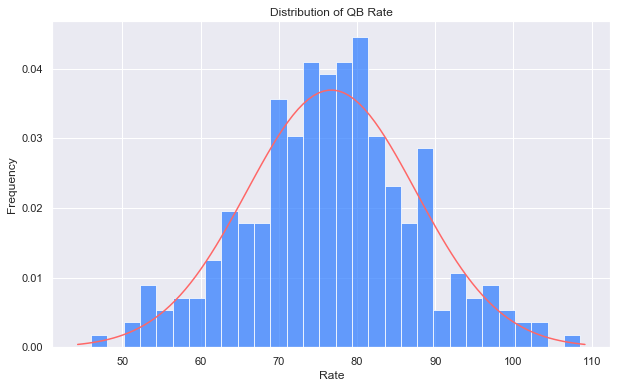

In [8]:
plot_hist_by_var(all_qb_stats, 'Rate')

Case quarterbacks distribution by probability plot

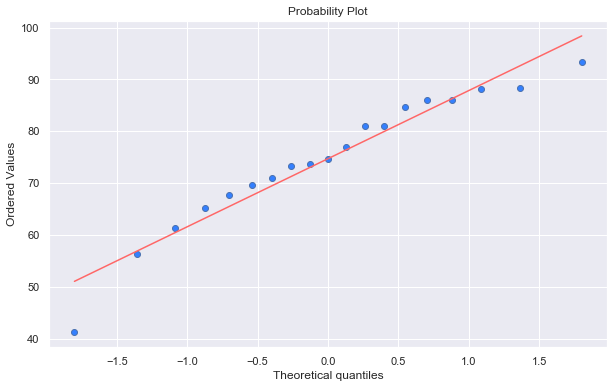

In [9]:
probplot_by_var(case_qbs, 'Rate')

Select control quaterbacks distribution

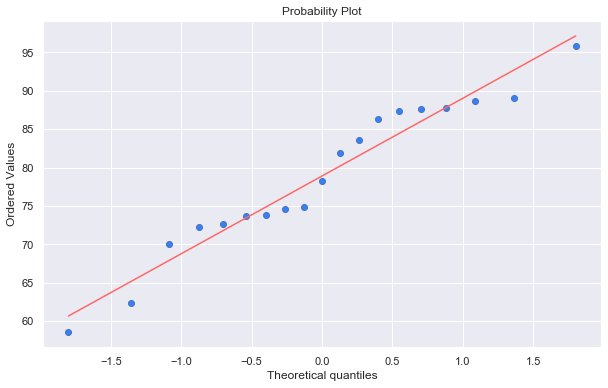

In [10]:
probplot_by_var(case_qbs, 'Rate', select_ctrls)

# Compare Pre and Post Surgery for Case QBs 

https://journals.physiology.org/doi/pdf/10.1152/ajplung.00238.2017

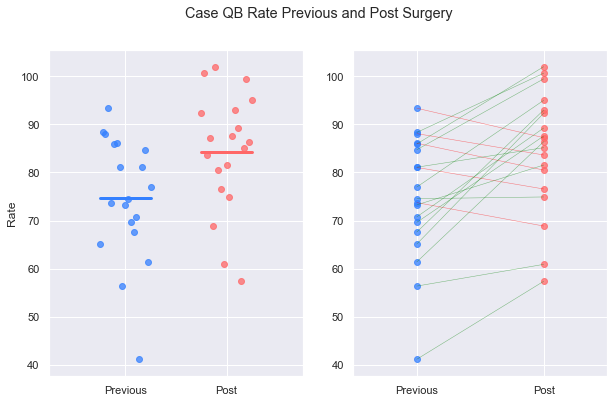

In [11]:
plot_pre_post(case_prev, case_post, 'Rate')

# Compare Case and Control QBs Pre and Post

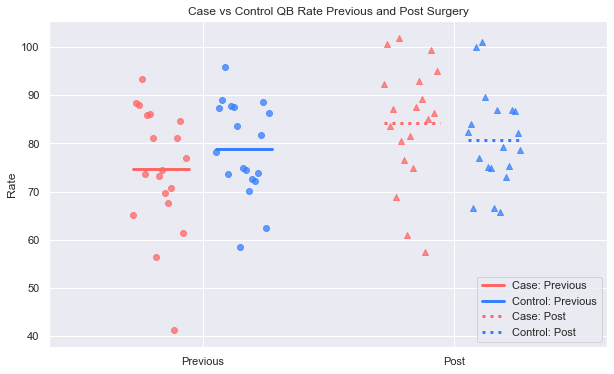

In [12]:
plot_case_control(case_prev, case_post, ctrl_prev, ctrl_post, 'Rate')

# Plot Case and Control QBs Performance by Year

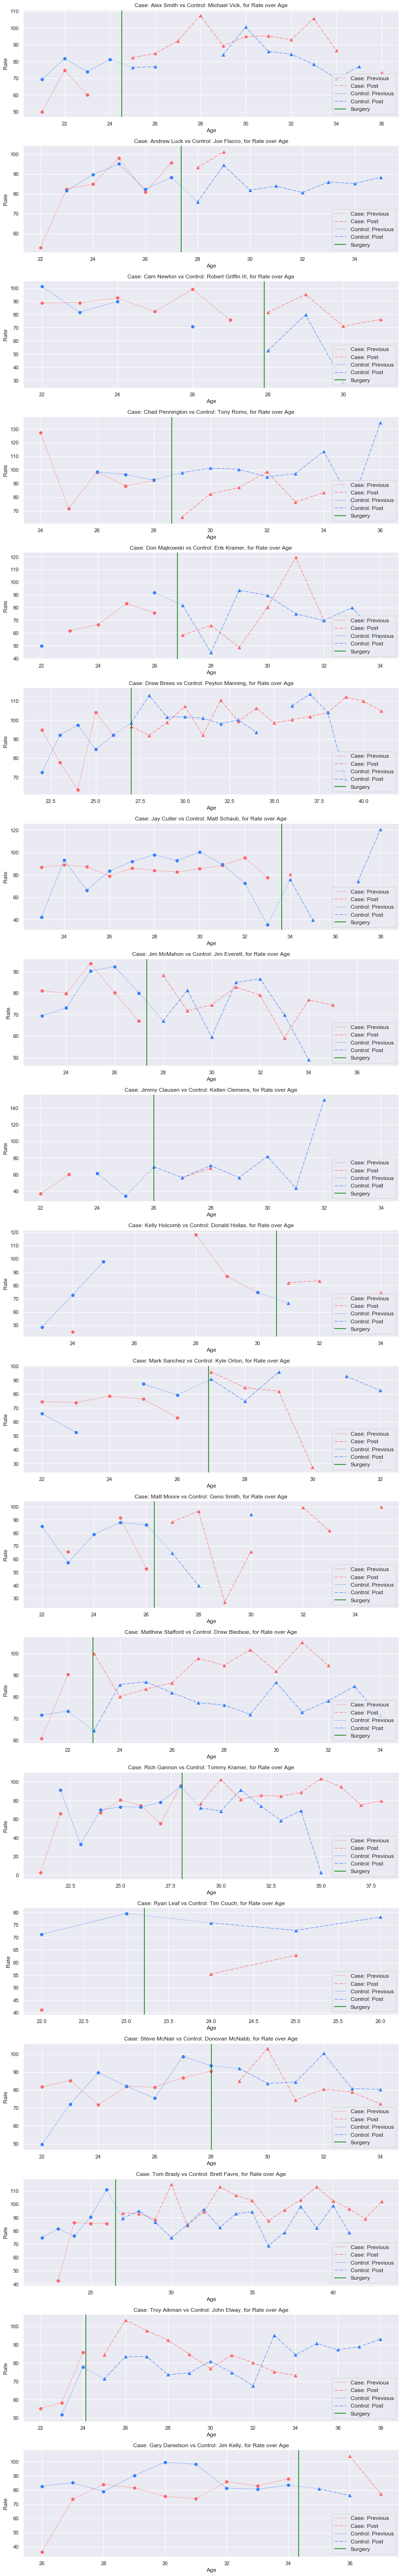

In [13]:
plot_case_control_by_year(case_qbs, select_ctrls, 'Rate')

# Compare QBs to Entire QB Population

In [80]:
case_avg = get_avg_stats_by_age(case_qbs)
ctrl_avg = get_avg_stats_by_age(pd.DataFrame(columns=['Name'],data=select_ctrls.values()))
pop_avg = get_avg_stats_by_age(ctrl_qbs)

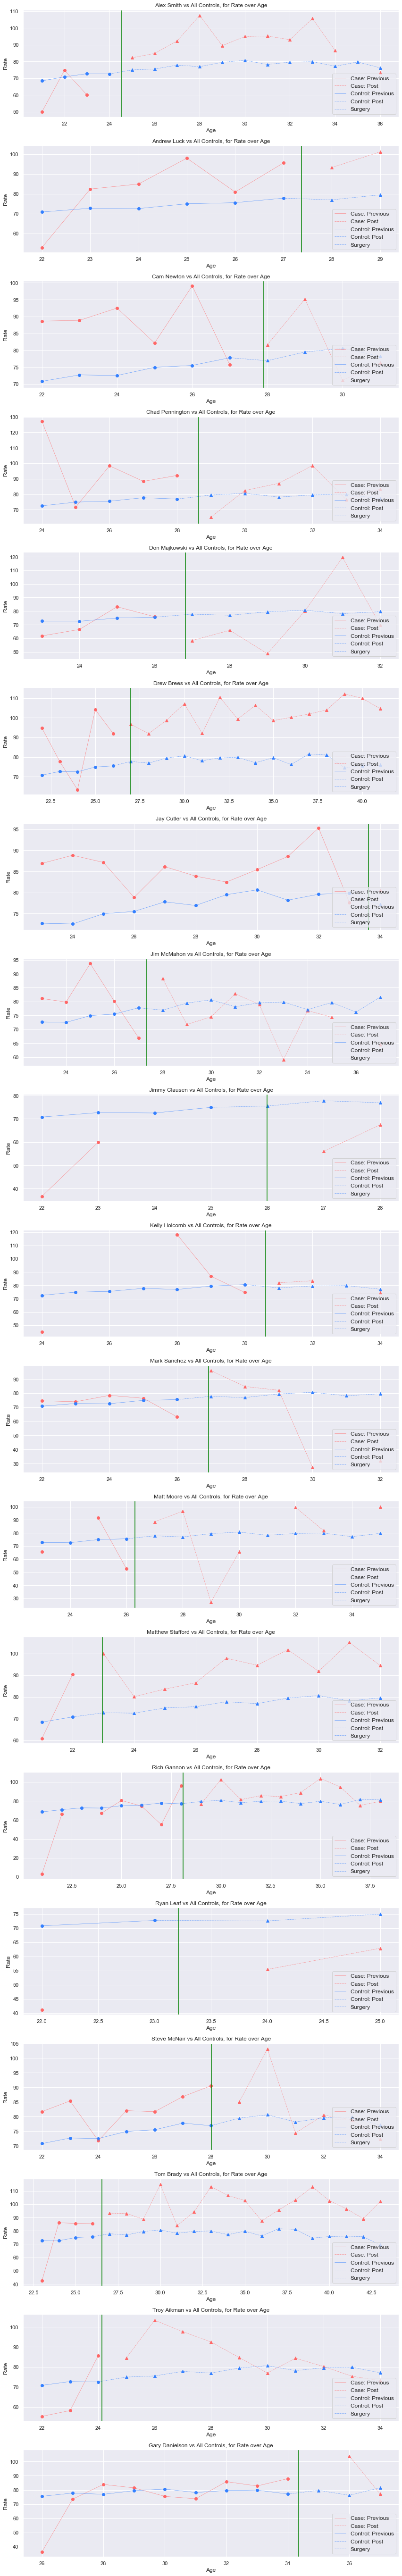

In [146]:
plot_case_pop_by_year(case_qbs, pop_avg, 'Rate')

# Visualize Average Performance vs Age

Case QBs

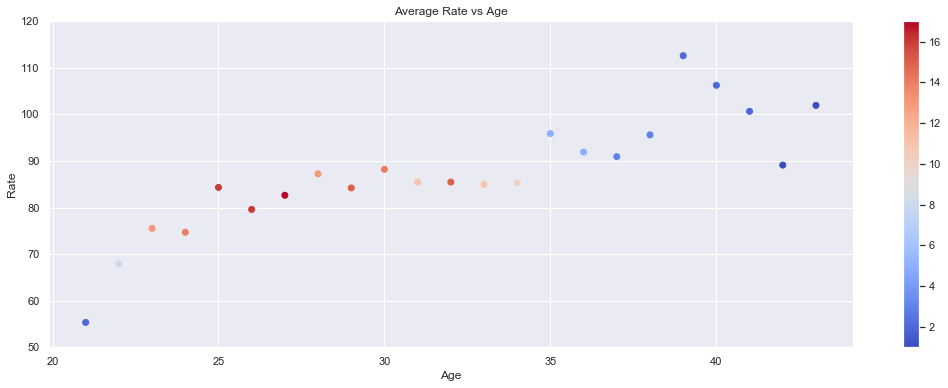

In [255]:
plot_avg_var_by_year(case_avg, 'Rate')

Selected controls

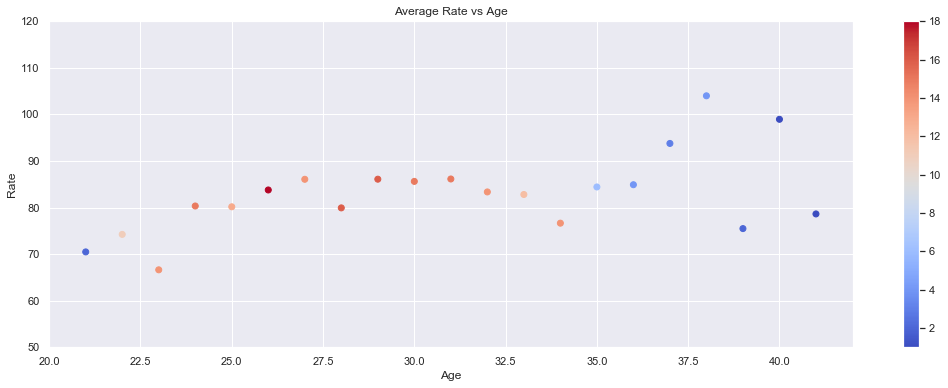

In [256]:
plot_avg_var_by_year(ctrl_avg, 'Rate')

Entire population

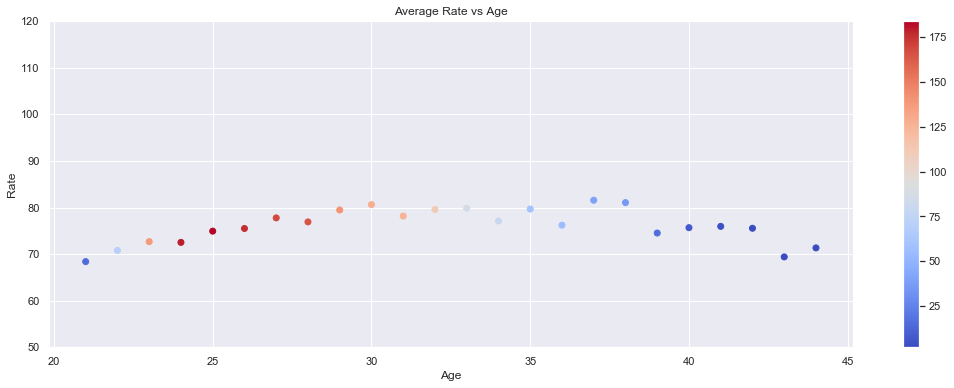

In [257]:
plot_avg_var_by_year(pop_avg, 'Rate')

# Visualize Case and Control QBs vs Population

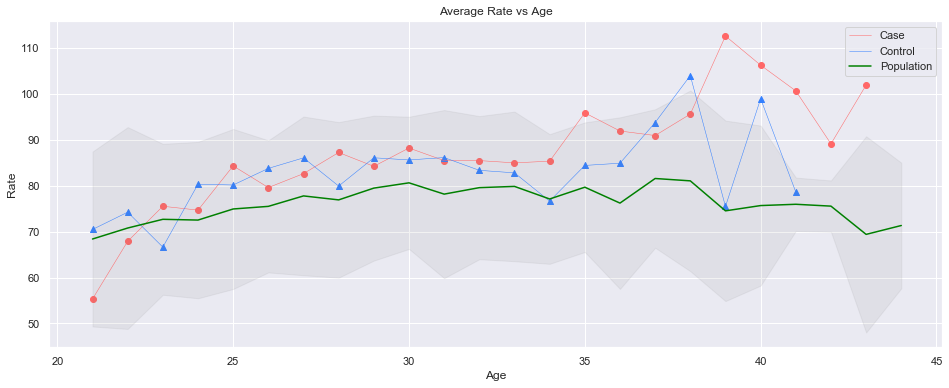

In [205]:
plot_case_ctrl_pop(case_avg, ctrl_avg, pop_avg, 'Rate')

# Test Statistical Significance in Performance Changes

In [85]:
ttest_rel_by_var(case_prev, case_post, 'Rate');

Rate
Previous: 74.7038    Post: 84.3321    Difference: +9.6283
       n: 19      t-value: -3.6670       p-value: 0.0018


# Test Statistical Significance between Case and Control

Previous

In [86]:
ttest_ind_by_var(case_prev, ctrl_prev, 'Rate');

Rate
Case: 74.7038    Control: 78.9109    Difference: -4.2071
   n: 19         t-value: -1.1332       p-value: 0.2646


Post

In [87]:
ttest_ind_by_var(case_post, ctrl_post, 'Rate');

Rate
Case: 84.3321    Control: 80.6392    Difference: +3.6929
   n: 19         t-value: 1.0077       p-value: 0.3203


# Gain Score Analysis

Compare difference between the gains from pre and post, between the case and control groups

https://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1212&context=pare

In [9]:
ttest_ind_gsa(case_prev, case_post, ctrl_prev, ctrl_post, 'Rate');

Rate
Case: 9.6283    Control: 1.7282    Gain Score: +7.9000
   n: 19        t-value: 2.2642       p-value: 0.0297


In [13]:
for var in ['Rate', 'Cmp%', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A', 'Games']:
    print(var, ttest_ind_gsa(inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post, var))

Rate
Case: 84.3321    Control: 69.4128    Difference: +14.9193
   n: 19         t-value: 2.6273       p-value: 0.0138
Rate (14.919285735768057, 0.013806272097948364)
Cmp%
Case: 61.5307    Control: 53.6434    Difference: +7.8874
   n: 19         t-value: 2.7875       p-value: 0.0094
Cmp% (7.887352736556238, 0.009435500882747723)
Cmp
Case: 18.7180    Control: 14.8340    Difference: +3.8840
   n: 19         t-value: 1.9744       p-value: 0.0583
Cmp (3.884001836019328, 0.05827563465041386)
Att
Case: 29.8854    Control: 25.8815    Difference: +4.0038
   n: 19         t-value: 1.5126       p-value: 0.1416
Att (4.003841237718113, 0.14159902738644287)
Yds
Case: 207.8934    Control: 172.2008    Difference: +35.6926
   n: 19         t-value: 1.5501       p-value: 0.1323
Yds (35.692645853984686, 0.13234073182980038)
TD
Case: 1.2850    Control: 0.9576    Difference: +0.3273
   n: 19         t-value: 1.5544       p-value: 0.1313
TD (0.327338943500154, 0.13132522977092706)
Int
Case: 0.8136    Contro

# Check Statistical Power

Statistical power ideally > 0.80 for robust studies, but in small sample size studies it decreases. It is < 0.15 in a NBA ACL performance outcome study https://www.arthroscopyjournal.org/article/S0749-8063(09)00193-5/fulltext. 

In [1]:
calc_power(case_prev, case_post, ctrl_prev, ctrl_post)

NameError: name 'calc_power' is not defined

# Compare Surgery vs Non-Surgery

In [12]:
inj_qbs = pd.read_csv('qb-data/injured_qbs.csv')
inj_prev, inj_post = get_before_after_age(inj_qbs)
inj_post.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Marc Bulger,52,30.537750,18.884615,31.788462,60.686154,209.269231,0.980769,0.807692,78.578846,2.653846,18.903846,6.600577,5.950000
1,Derek Anderson,58,26.891069,14.500000,26.775862,54.610690,173.620690,0.948276,0.948276,72.334483,1.258621,8.568966,6.566897,5.687586
2,Kyle Boller,9,28.699000,12.666667,22.888889,51.236667,120.000000,0.333333,1.111111,52.733333,2.222222,15.111111,5.161111,1.711111
3,Bruce Gradkowski,3,28.625333,4.333333,9.666667,45.706667,58.000000,0.333333,0.333333,59.266667,0.333333,2.333333,5.470000,3.523333
4,Jameis Winston,28,24.951071,22.500000,36.214286,62.448929,291.571429,1.857143,1.571429,88.478571,2.714286,16.071429,8.143929,7.312143


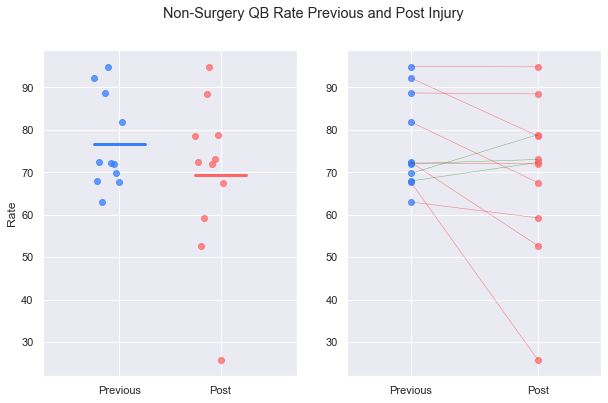

In [116]:
plot_pre_post(inj_prev, inj_post, 'Rate')

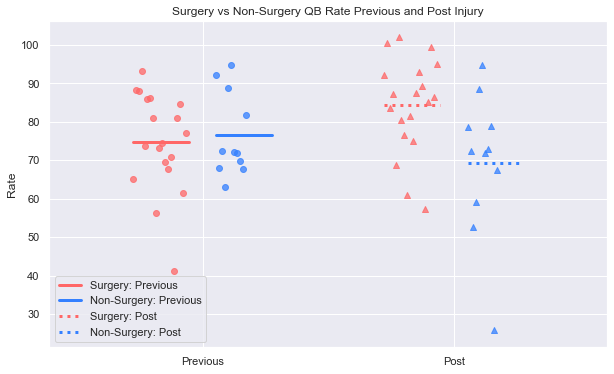

In [117]:
plot_case_control(case_prev, case_post, inj_prev, inj_post, 'Rate')

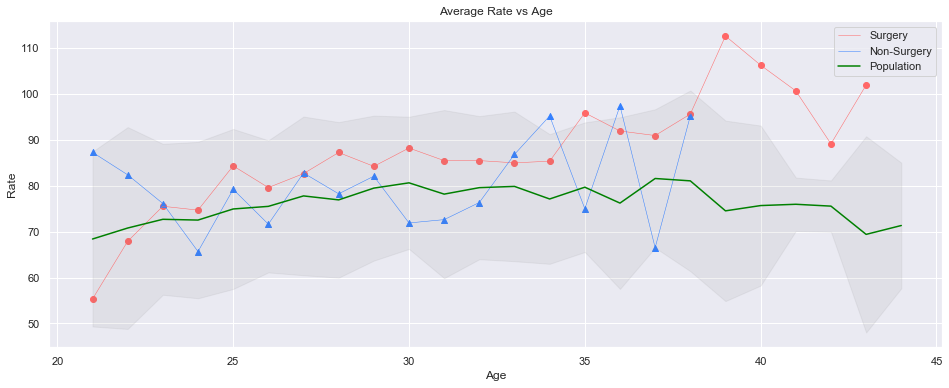

In [118]:
inj_avg = get_avg_stats_by_age(inj_qbs)
plot_case_ctrl_pop(case_avg, inj_avg, pop_avg, 'Rate')

In [326]:
for var in ['Rate', 'Cmp%', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A', 'Games']:
    print(var, ttest_rel_by_var(inj_prev, inj_post, var))

Rate
Previous: 76.6066    Post: 69.4128    Difference: -7.1938
       n: 11      t-value: 1.6563       p-value: 0.1287
Rate (-7.193791070183906, 0.1286529515836486)
Cmp%
Previous: 56.9930    Post: 53.6434    Difference: -3.3497
       n: 11      t-value: 1.3444       p-value: 0.2085
Cmp% (-3.349662417640431, 0.20853323485113642)
Cmp
Previous: 16.2628    Post: 14.8340    Difference: -1.4288
       n: 11      t-value: 1.0241       p-value: 0.3299
Cmp (-1.4288341394304727, 0.3299371930657933)
Att
Previous: 27.9038    Post: 25.8815    Difference: -2.0222
       n: 11      t-value: 0.9176       p-value: 0.3804
Att (-2.0222416744649223, 0.3804246788494333)
Yds
Previous: 195.3330    Post: 172.2008    Difference: -23.1322
       n: 11      t-value: 1.4921       p-value: 0.1665
Yds (-23.13221065319371, 0.1665268494751705)
TD
Previous: 1.1054    Post: 0.9576    Difference: -0.1478
       n: 11      t-value: 0.9362       p-value: 0.3712
TD (-0.14777284531037183, 0.3712308525666679)
Int
Previous: 

In [327]:
for var in ['Rate', 'Cmp%', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A', 'Games']:
    print(var, ttest_ind_by_var(case_post, inj_post, var))

Rate
Case: 84.3321    Control: 69.4128    Difference: +14.9193
   n: 19         t-value: 2.6273       p-value: 0.0138
Rate (14.919285735768057, 0.013806272097948364)
Cmp%
Case: 61.5307    Control: 53.6434    Difference: +7.8874
   n: 19         t-value: 2.7875       p-value: 0.0094
Cmp% (7.887352736556238, 0.009435500882747723)
Cmp
Case: 18.7180    Control: 14.8340    Difference: +3.8840
   n: 19         t-value: 1.9744       p-value: 0.0583
Cmp (3.884001836019328, 0.05827563465041386)
Att
Case: 29.8854    Control: 25.8815    Difference: +4.0038
   n: 19         t-value: 1.5126       p-value: 0.1416
Att (4.003841237718113, 0.14159902738644287)
Yds
Case: 207.8934    Control: 172.2008    Difference: +35.6926
   n: 19         t-value: 1.5501       p-value: 0.1323
Yds (35.692645853984686, 0.13234073182980038)
TD
Case: 1.2850    Control: 0.9576    Difference: +0.3273
   n: 19         t-value: 1.5544       p-value: 0.1313
TD (0.327338943500154, 0.13132522977092706)
Int
Case: 0.8136    Contro

In [148]:
ttest_ind_by_var(case_prev, inj_prev, 'AY/A');

AY/A
Case: 5.5597    Control: 5.7035    Difference: -0.1438
   n: 19         t-value: -0.2464       p-value: 0.8071


In [134]:
ttest_ind_by_var(case_post, inj_post, 'AY/A');

AY/A
Case: 6.4094    Control: 4.9975    Difference: +1.4119
   n: 19         t-value: 2.2792       p-value: 0.0305


In [136]:
effect_size = Cohens_d(case_post, inj_post)
analysis = TTestIndPower()
power = analysis.solve_power(effect_size, power=None, nobs1=len(case_post), ratio=19/11, alpha=0.05)
power

Games    0.640697
Age      0.396545
Cmp      0.720592
Att      0.495873
Cmp%     0.948659
Yds      0.515177
TD       0.517359
Int      0.483122
Rate     0.923013
Sk       0.130277
Yds.1    0.052543
Y/A      0.420645
AY/A     0.835792
dtype: float64

# Compare Player Stats Radially

In [32]:
def radar_plot(df1, df2, df3=None, df4=None, prevpost=False, max_val=1.5):    
    label1 = df1.index[0]+' (Previous)' if prevpost else df1.index[0]
    label2 = df2.index[0]+' (Post)' if prevpost else df2.index[0]
    if df3 is not None and df4 is not None:
        plt.figure(figsize=(18,18))
        ax = plt.subplot(121, polar=True)
    else: 
        plt.figure(figsize=(14,8))
        ax = plt.subplot(111, polar=True)
        plt.title('{} vs {}: % of NFL Average'.format(label1, label2))

    categories=list(df1)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.set_rlabel_position(0)
    yticks = [max_val*i/6 for i in range(1,6)]
    plt.yticks(yticks, [str(e) for e in yticks], color='grey', size=14)
    plt.ylim(0,max_val)
    colors = ['blue','red']
    
    values1 = df1.values.flatten().tolist()
    values1 += values1[:1]
    ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=label1)
    ax.fill(angles, values1, color=colors[0], alpha=0.1)
    values2 = df2.values.flatten().tolist()
    values2 += values2[:1]
    ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=label2)
    ax.fill(angles, values2, color=colors[1], alpha=0.1)
    plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
    
    if df3 is not None and df4 is not None:
        plt.title('{} vs {}: Previous, % of NFL Average'.format(label1, label2))
        ax = plt.subplot(122, polar=True)
        plt.xticks(angles[:-1], categories, color='black', size=12)
        ax.set_rlabel_position(0)
        yticks = [max_val*i/6 for i in range(1,6)]
        plt.yticks(yticks, [str(e) for e in yticks], color='grey', size=14)
        plt.ylim(0,max_val)
        values1 = df3.values.flatten().tolist()
        values1 += values1[:1]
        ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=df3.index[0])
        ax.fill(angles, values1, color=colors[0], alpha=0.1)
        values2 = df4.values.flatten().tolist()
        values2 += values2[:1]
        ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=df4.index[0])
        ax.fill(angles, values2, color=colors[1], alpha=0.1)
        plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
        plt.title('{} vs {}: Post, % of NFL Average'.format(df3.index[0], df4.index[0]))
    plt.show()
    
def get_player_percent(player, df, all_qbs):
    res = df[df['Name']==player]
    res.set_index('Name', drop=True, inplace=True)
    res.drop(columns=['Age', 'Games'], inplace=True)
    res = res[['Rate', 'Cmp%', 'Yds', 'Cmp', 'Att', 'Y/A', 'AY/A', 'TD', 'Int', 'Sk', 'Yds.1']]
    for var in res.columns:
        avgvar = all_qbs[var].mean()
        # invert the negative stats (Int, Sk, Yds.1)
        if var == 'Int' or var == 'Sk' or var == 'Yds.1':
            res[var] = 1 - (abs(res[var]-avgvar)/avgvar)
        else:
            res[var] = res[var]/avgvar
#         res[var] = res[var]/avgvar
    return res

avg sacks = 5.5
smith sacks = 9
vick sacks = 3

want 2.5/5.5 = 0.45 + 1
vick sacks = 1.45 

smith 9/5.5 = 

abs of sacks-avgsacks
div by avgsacks
1 + ans if less than 
1 - ans if more than 


In [33]:
smith_prev = get_player_percent('Alex Smith', case_prev, all_qb_stats)
smith_post = get_player_percent('Alex Smith', case_post, all_qb_stats)
vick_prev = get_player_percent('Michael Vick', ctrl_prev, all_qb_stats)
vick_post = get_player_percent('Michael Vick', ctrl_post, all_qb_stats)

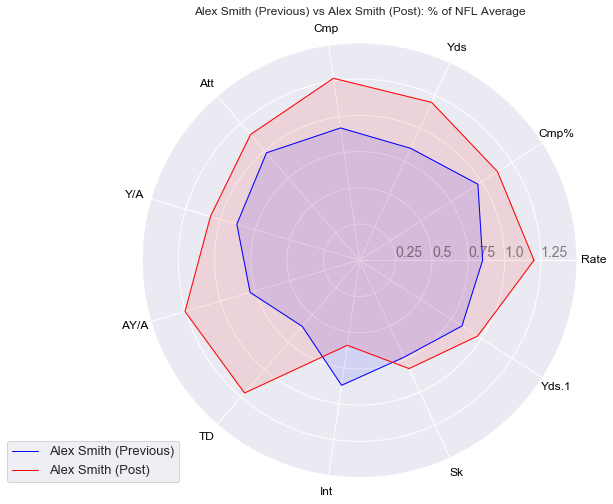

In [34]:
radar_plot(smith_prev, smith_post, prevpost=True)

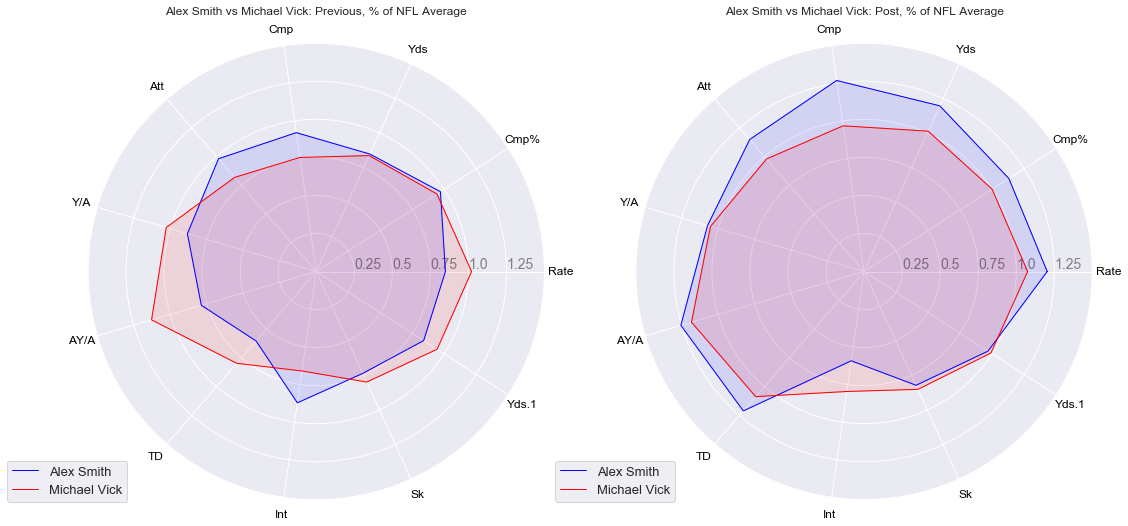

In [35]:
radar_plot(smith_prev, vick_prev, smith_post, vick_post)

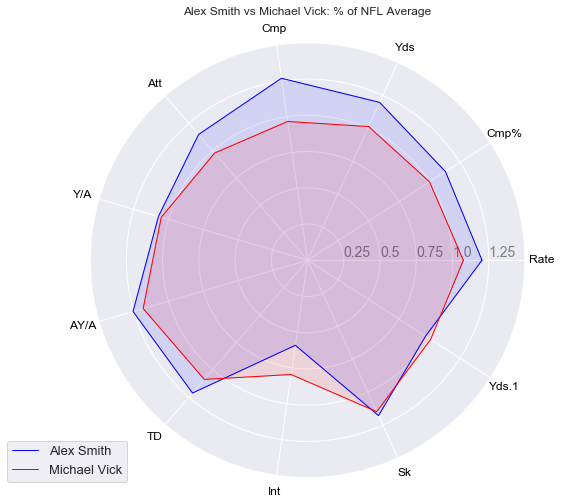

In [265]:
radar_plot(smith_post, vick_post)

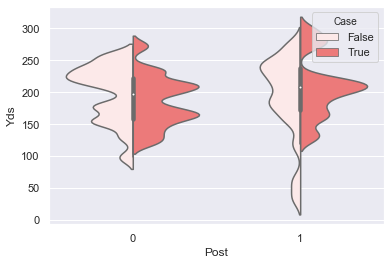

In [321]:
test_prev = case_prev
test_prev['Post'] = 0
test_post = case_post
test_post['Post'] = 1
test = test_prev.append(test_post)
test['Case'] = True
test_c_prev = ctrl_prev
test_c_prev['Post'] = 0
test_c_post = ctrl_post
test_c_post['Post'] = 1
test_c = test_c_prev.append(test_c_post)
test_c['Case'] = False
the_test = test.append(test_c)
sns.violinplot('Post', 'Yds', hue='Case', data=the_test, split=True, bw=0.2, color=red)
# the_test

# Compare Non-Surgery Cases to Controls

Next steps:
 - look at scraping other passing data i.e. longest pass from PFR
 - look at using 2 controls per player